MedClusterAI: CKD Risk Prediction & Patient Phenotype Clustering System

In [2]:
import pandas as pd

df=pd.read_csv('kidney_disease.csv')

print("Shape: ",df.shape)


Shape:  (400, 26)


In [3]:
# dropping unnecessary columns

df.drop('id',axis=1,inplace=True)

In [4]:
#
df['classification']=df['classification'].astype(str).str.strip().replace({
    'ckd':1,
    'notckd': 0
})


C:\Users\rahul\AppData\Local\Temp\ipykernel_16188\3031786646.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['classification']=df['classification'].astype(str).str.strip().replace({


In [5]:
# encoding categorical binary fields

# Map binary categorical columns to numeric values
binary_map = {
    'yes': 1, 'no': 0,
    'present': 1, 'notpresent': 0,
    'abnormal': 1, 'normal': 0,
    'good': 1, 'poor': 0
}

binary_columns = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().map(binary_map)


In [6]:
# convert non-numeric to float

for col in ['pcv', 'wc', 'rc']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

'''
Why pd.to_numeric(..., errors='coerce') is safer:
Tries to convert each value to float

If it fails, it replaces the bad value with NaN (which you handle later with .fillna())

Does not crash the program

🚫 What happens if you use .astype(float)?
This will throw an error if there's even one invalid string (like '?')

It’s not fault-tolerant. The whole script will crash on the first bad value.

'''
df = df.fillna(df.median(numeric_only=True))


In [7]:
# Fill numeric columns with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median(numeric_only=True))

# Convert remaining object columns to numeric if possible
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill remaining NaNs with median (again, after object->float conversion)
df = df.fillna(df.median(numeric_only=True))


In [8]:
# checking phase-1

print("Missing Values: ",df.isnull().sum().sum())
print("Target Distribution: \n",df['classification'].value_counts())

Missing Values:  0
Target Distribution: 
 classification
1    250
0    150
Name: count, dtype: int64


Phase 2: EDA + Clustering (KMeans + PCA)

In [9]:
# ensuring numeric values
# Convert object columns to numeric safely
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values
df = df.fillna(df.median(numeric_only=True))


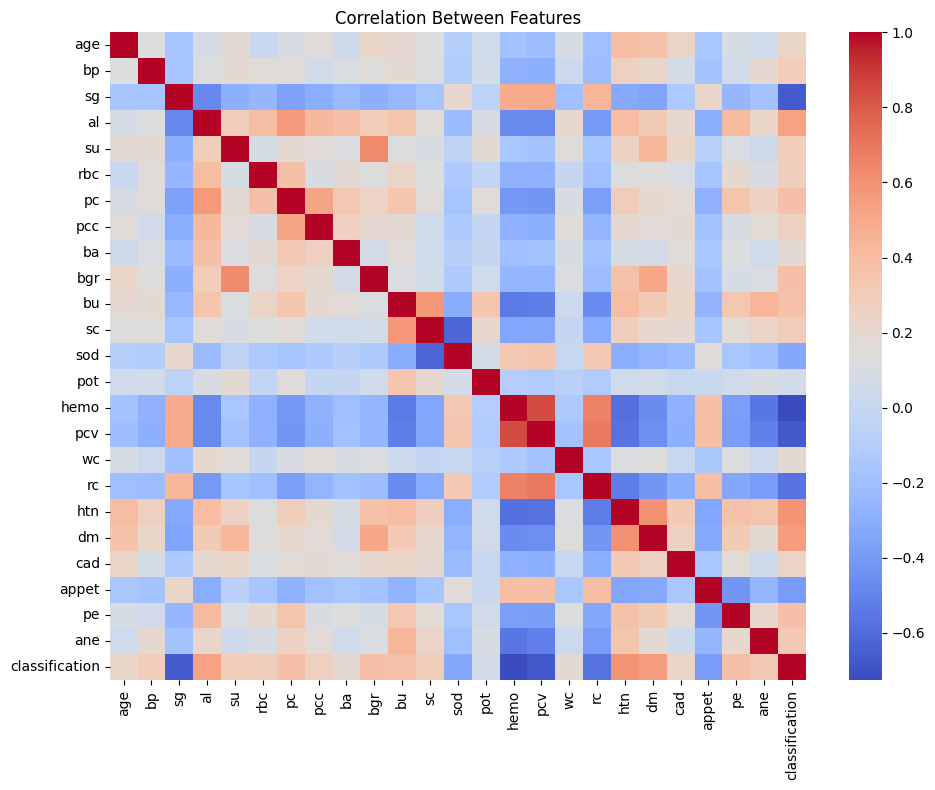

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=False,cmap='coolwarm')
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()

In [11]:
# select features for clustering

cluster_features=['bgr','sc','hemo','pcv','bp']
X_cluster=df[cluster_features]


In [12]:
# standarize features

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_cluster)

In [13]:
# apply KMeans

from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=3,random_state=42)
df['cluster']=kmeans.fit_predict(X_scaled)


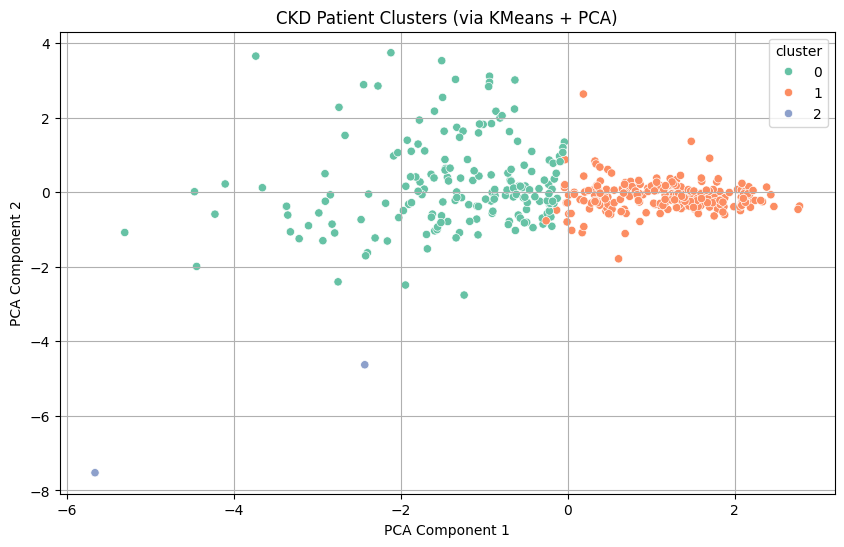

In [14]:
# visualize 

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='Set2', data=df)
plt.title("CKD Patient Clusters (via KMeans + PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [15]:
# View average profile per cluster
cluster_summary = df.groupby('cluster')[cluster_features].mean()
print(cluster_summary)


                bgr         sc       hemo        pcv         bp
cluster                                                        
0        182.813559   4.469774  10.225141  32.361582  82.485876
1        114.819005   1.283258  14.405430  44.493213  71.855204
2        146.000000  62.050000  11.775000  36.000000  75.000000


In [16]:
# compare the cluster label with classification

pd.crosstab(df['cluster'], df['classification'])


classification,0,1
cluster,,
0,0,177
1,150,71
2,0,2


Predictive Modeling for CKD Detection

In [17]:
# drop non-feature columns (e.g -> PCA, Clustering)

X=df.drop(columns=['classification','cluster','PCA1','PCA2'],errors='ignore')
y=df['classification']


In [18]:
# train-test split

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [19]:
# Fill any remaining NaNs in train/test features
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [20]:
# training and comparing multiple models

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

models={
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss',use_label_encoder=False),
    'Logistic Regression': LogisticRegression(max_iter=100),
    'KNN': KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train,y_train)
    preds=model.predict(X_test)
    acc=accuracy_score(y_test,preds)
    print(f"✅ {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    print("=" * 60)

✅ Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

✅ XGBoost Accuracy: 0.9875
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.98      0.99        50

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

✅ Logistic Regression Accuracy: 0.8500
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        30
           1       0.90      0.86      0.88        50

    accuracy                           0.85        80
   macro avg       0.84      

c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
print("Original X shape:", X.shape)
print("X.columns length:", len(X.columns))
print(X.columns.tolist())


Original X shape: (400, 24)
X.columns length: 24
['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


In [22]:
X = df.drop(columns=['id', 'classification', 'Cluster', 'PCA1', 'PCA2'], errors='ignore')


In [23]:
# Save clean feature names BEFORE imputation
feature_names = X.columns


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [25]:
from sklearn.impute import SimpleImputer
import pandas as pd

imputer = SimpleImputer(strategy='median')

# Impute the numeric data
X_train_np = imputer.fit_transform(X_train)
X_test_np = imputer.transform(X_test)

# ✅ Get correct columns based on imputed values (some may be dropped)
valid_column_mask = ~pd.isnull(imputer.statistics_)
valid_feature_names = feature_names[valid_column_mask]

# ✅ Wrap back into DataFrames
X_train = pd.DataFrame(X_train_np, columns=valid_feature_names)
X_test = pd.DataFrame(X_test_np, columns=valid_feature_names)


C:\Users\rahul\AppData\Local\Temp\ipykernel_16188\2048490551.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
C:\Users\rahul\AppData\Local\Temp\ipykernel_16188\2048490551.py:23: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rahul\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


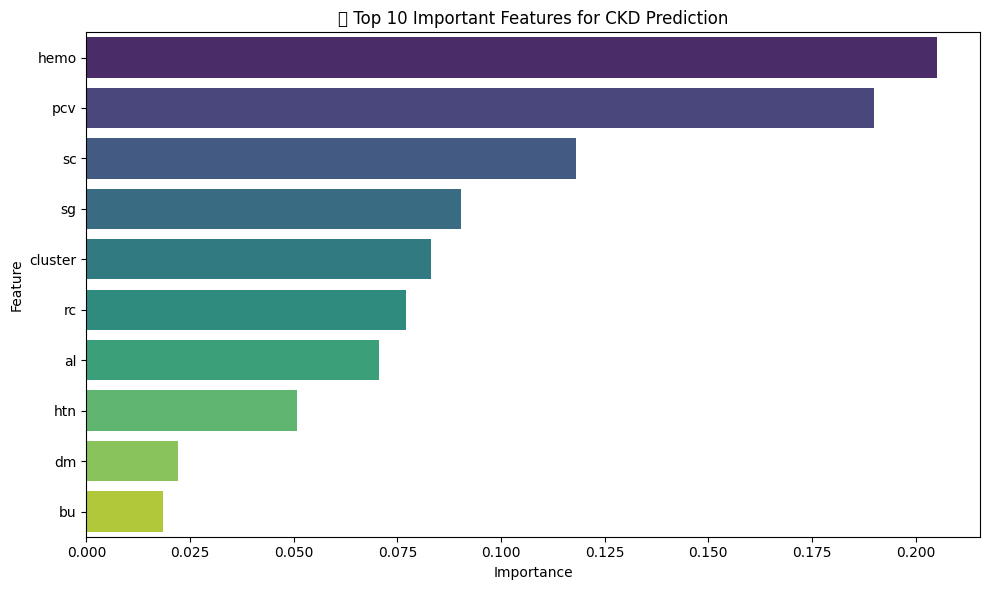

In [26]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Feature importances
importances = rf_model.feature_importances_

feat_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
plt.title("🔍 Top 10 Important Features for CKD Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [27]:
print("Imputed X_train shape:", X_train_np.shape)
print("Feature names count:", len(valid_feature_names))


Imputed X_train shape: (320, 25)
Feature names count: 25


In [28]:
# as Random Forest is best model we select that

from sklearn.ensemble import RandomForestClassifier

final_model=RandomForestClassifier(random_state=42)
final_model.fit(X_train,y_train)


RandomForestClassifier(random_state=42)

In [29]:
# saving the model

import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib

# Define models
models = {
    "random_forest": RandomForestClassifier(random_state=42),
    "logistic_regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "xgboost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and save each
for name, model in models.items():
    print(f"🔧 Training {name}...")
    model.fit(X_train, y_train)

    file_path = f"models/{name}.pkl"
    joblib.dump(model, file_path)
    print(f"✅ Saved {name} to {file_path}")



🔧 Training random_forest...
✅ Saved random_forest to models/random_forest.pkl
🔧 Training logistic_regression...
✅ Saved logistic_regression to models/logistic_regression.pkl
🔧 Training xgboost...
✅ Saved xgboost to models/xgboost.pkl


c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [30]:
import joblib

joblib.dump(kmeans, "models/kmeans_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")  # optional but recommended for consistency


['models/scaler.pkl']

In [32]:
# 🔁 Binary conversion map
binary_map = {
    'yes': 1, 'no': 0,
    'present': 1, 'notpresent': 0,
    'abnormal': 1, 'normal': 0,
    'good': 1, 'poor': 0
}

# 🧼 Clean binary categorical columns
binary_columns = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
for col in binary_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str).str.strip().map(binary_map)
    if col in X_test.columns:
        X_test[col] = X_test[col].astype(str).str.strip().map(binary_map)

# 🔢 Convert numeric text columns to float
for col in ['pcv', 'wc', 'rc']:
    if col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    if col in X_test.columns:
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# 🧽 Fill NaNs
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_test.median(numeric_only=True))
